In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from kernel import load_min_data, prepare_data, NetModel

In [2]:
train_end = '2018-05-13 00:00' # we use 2016 - 2018 for training
df_train, df_test = load_min_data()
df_train.head()

,high,open,low,close,volume,oi
time,,,,,,
2016-05-13 14:00:00,645,632,632,645,148052,3570070
2016-05-13 14:05:00,647,644,639,640,202724,3586682
2016-05-13 14:10:00,643,640,636,641,94164,3578016
2016-05-13 14:15:00,655,640,634,651,333452,3612632
2016-05-13 14:20:00,657,652,639,641,300840,3585022


## Prepare Data for Model
> - transform data into images consisting the past 1000 points <br>
> - aim to predict the return after 3 periods = 15 mins <br>
> - next split training data into training set and validation set (for model selection) <br>

In [3]:
time_window = 1000
forecast_period = 3
X_train, X_valid, y_train, y_valid = prepare_data(df_train, time_window, forecast_period)
print(f'training set size: {X_train.shape[0]}, array shape: {X_train.shape}')
print(f'validation set size: {X_valid.shape[0]}, and array shape: {X_valid.shape}')

training set size: 8682, array shape: (8682, 1000, 6, 1)
validation set size: 3721, and array shape: (3721, 1000, 6, 1)


## Build Convolution AutoEncoder Network
> The reommanded number of filters is (64, 32, 16). <br>
> If you don't have a GPU-accelerated machine, use small number of filters such as (16, 8, 8). Or try google colab.

In [4]:
net = NetModel(X_train, X_valid, y_train, y_valid)
conv_window=(3, 3)
pooling_window=(5, 1)
n_filters=(32, 16, 8)
net.build_net(conv_window, pooling_window, n_filters)

shape of input (None, 1000, 6, 1)
shape after first conv (None, 1000, 6, 32)
shape after first pooling (None, 200, 6, 32)
shape after second conv (None, 200, 6, 16)
shape after second pooling (None, 40, 6, 16)
shape after third conv (None, 40, 6, 8)
shape of encoded (None, 8, 6, 8)
shape after upsample third pooling (None, 40, 6, 8)
shape after decode third conv (None, 40, 6, 8)
shape after upsample second pooling (None, 200, 6, 8)
shape after decode second conv (None, 200, 6, 16)
shape after upsample first pooling (None, 1000, 6, 16)
shape after decode first conv (None, 1000, 6, 32)
shape after decode to input (None, 1000, 6, 1)


## Train AutoEncoder and Examine the Reconstruction

In [5]:
epoches = 3
batch_size = 64
net.train_encoder(epoches, batch_size)

Epoch 1/3
8682/8682 [==============================] - 174s 20ms/step - loss: 1472.3104
Epoch 2/3
8682/8682 [==============================] - 206s 24ms/step - loss: 377.1670
Epoch 3/3
8682/8682 [==============================] - 197s 23ms/step - loss: 355.8918


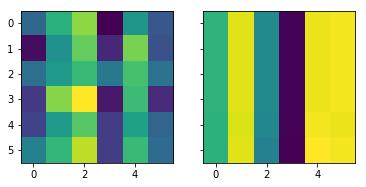

In [6]:
net.get_encoded_series()
img = X_train[0][:, :, 0].copy()
img_c = net.reconstructed_train[0][:, :, 0].copy()
img_c = (MinMaxScaler().fit_transform(img_c) * 255).astype('int')

b=20
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(img[6*(b-1):6*b, :])
ax2.imshow(img_c[6*(b-1):6*b, :])
plt.show()

## Train Asset Return Predictor
- 'rf' means random forest classifier
- 'xgb' is XGBoost classifier
- 'n_search' is the number of random grid-search to perform

In [10]:
import time
start_time = time.time()
net.train_classifier('rf', n_search=10)
print(time.time() - start_time)

training acc: 0.6446671273900023
              precision    recall  f1-score   support

         0.0       0.49      0.15      0.23      1697
         1.0       0.55      0.87      0.67      2024

   micro avg       0.54      0.54      0.54      3721
   macro avg       0.52      0.51      0.45      3721
weighted avg       0.52      0.54      0.47      3721

145.05216813087463


## Applying Strategy